In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import yaml

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

In [3]:
df['FiscalYear'] = df['MissionDate'].copy()
df.set_index('MissionDate', drop=False, inplace=True)
df.index.name = 'FiscalYear'

# Grouping records by exact date, fiscal year, MissionID,
# removal or transfer status, unique pickup/dropoff, juvenile status.
# Can't group by nationality here or it splits flights up and obscures trends
g = df.groupby([pd.Grouper(freq='AS-OCT'), 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])

In [4]:
table = g[['AlienMasterID', 'MissionID']].nunique().reset_index()

In [5]:
table.head()

,FiscalYear,MissionDate,R-T,PULOC,DropLoc,AlienMasterID,MissionID
0,2010-10-01,2010-10-01,R,KAEX,MHLM,97,1
1,2010-10-01,2010-10-01,R,KBFL,KSAN,13,1
2,2010-10-01,2010-10-01,R,KCSG,MSLP,33,1
3,2010-10-01,2010-10-01,R,KDEN,KHRL,42,1
4,2010-10-01,2010-10-01,R,KELP,KHRL,46,1


In [6]:
table.set_index('MissionDate', inplace=True)

In [7]:
table.head()

,FiscalYear,R-T,PULOC,DropLoc,AlienMasterID,MissionID
MissionDate,,,,,,
2010-10-01,2010-10-01,R,KAEX,MHLM,97,1
2010-10-01,2010-10-01,R,KBFL,KSAN,13,1
2010-10-01,2010-10-01,R,KCSG,MSLP,33,1
2010-10-01,2010-10-01,R,KDEN,KHRL,42,1
2010-10-01,2010-10-01,R,KELP,KHRL,46,1


In [8]:
table.columns = ['year', 'R-T', 'pickup_airport', 'dropoff_airport', 'passengers', 'flights']
all_kbfi = (table['pickup_airport'] == 'KBFI') | (table['dropoff_airport'] == 'KBFI')
# table.to_csv('../output/flight_summary.csv.gz', index=False, compression='gzip', encoding='utf-8', sep='|')

In [9]:
# flights = table
flights = table[all_kbfi]
# flights = pd.read_csv('../output/flight_summary.csv.gz', compression='gzip', sep='|')
# flights = pd.read_csv('../output/guatemala_transfers.csv.gz', compression='gzip', sep='|')

In [10]:
flights.head()

,year,R-T,pickup_airport,dropoff_airport,passengers,flights
MissionDate,,,,,,
2010-10-02,2010-10-01,R,KBFI,KSAN,53,1
2010-10-02,2010-10-01,T,KBFI,KIWA,1,1
2010-10-02,2010-10-01,T,KIWA,KBFI,26,1
2010-10-06,2010-10-01,R,KBFI,KHRL,18,1
2010-10-06,2010-10-01,T,KBFI,KIWA,28,1


In [11]:
flights['pickup_airport'] = flights['pickup_airport'].str.upper()
flights['dropoff_airport'] = flights['dropoff_airport'].str.upper()
# flights['pickup_airport'] = flights['PULOC'].str.upper()
# flights['dropoff_airport'] = flights['DropLoc'].str.upper()

/Users/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
flights_loc = set(pd.concat([flights['pickup_airport'], flights['dropoff_airport']]))

In [13]:
bad_airports = ['KKBL']

In [14]:
flights = flights[~flights['pickup_airport'].isin(bad_airports)]
flights = flights[~flights['dropoff_airport'].isin(bad_airports)]

In [15]:
airports = pd.read_csv('../../share/hand/GlobalAirportDatabase.csv.gz', compression='gzip', sep='|')

In [16]:
airports.head()

,ICAOCode,IATACode,AirportName,City,Country,LatitudeDegrees,LatitudeMinutes,LatitudeSeconds,LatitudeDirection,LongitudeDegrees,LongitudeMinutes,LongitudeSeconds,LongitudeDirection,Altitude,LatitudeDecimalDegrees,LongitudeDecimalDegrees
0,AYGA,GKA,GOROKA,GOROKA,PAPUA NEW GUINEA,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,NaN,LAE,PAPUA NEW GUINEA,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,MADANG,MADANG,PAPUA NEW GUINEA,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,MOUNT HAGEN,MOUNT HAGEN,PAPUA NEW GUINEA,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,NADZAB,NADZAB,PAPUA NEW GUINEA,6,34,11,S,146,43,34,E,73,-6.570,146.726


In [17]:
airports_loc = set(airports['ICAOCode'])

In [18]:
airports.set_index('ICAOCode', inplace=True)

In [19]:
airports_missing_loc = ['FLKK', 'FWKI', 'KABQ', 'VTBS']

In [20]:
airports = airports[~airports.index.isin(['FLKK', 'FWKI', 'KABQ', 'VTBS'])]

In [21]:
additional_airports = pd.read_csv('../../share/hand/locations.csv', quotechar='"')

In [22]:
additional_airports.columns = ['ICAOCode', 'CountryISO', 'State', 'City', 'LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']
additional_airports.set_index('ICAOCode', inplace=True)
additional_airports.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
BKPR,KS,Pristina,Slatina,42.572778,21.035833
EYVI,LT,Vilnius,Vilnius,54.636944,25.287778
FKYS,CM,Nsimalen,Nsimalen,3.722500,11.553333
FYWH,NaN,Windhoek,Windhoek,-22.486667,17.462500
GQNO,MR,Nouakchott,Nouakchott,18.310000,-15.969722


In [23]:
missing_airports = list(flights_loc.difference(airports_loc))
missing_airports.extend(airports_missing_loc)

In [24]:
airports_2 = additional_airports[additional_airports.index.isin(missing_airports)].copy()

In [25]:
airports_2.head()

,CountryISO,State,City,LatitudeDecimalDegrees,LongitudeDecimalDegrees
ICAOCode,,,,,
KIWA,US,AZ,Phoenix,33.307833,-111.655472
KNYL,US,AZ,Yuma,32.656667,-114.606111
FLKK,ZM,Lusaka,Lusaka,-15.331667,28.434167
FWKI,MW,Lilongwe,Lilongwe,-13.789167,33.780833
KABQ,US,NM,Albuquerque,35.039333,-106.610778


In [26]:
airports_2 = airports_2[['LatitudeDecimalDegrees', 'LongitudeDecimalDegrees']]

In [27]:
airports = pd.concat([airports, airports_2])

/Users/philneff/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [28]:
airports.loc['FLKK']

 AirportName                   NaN
Altitude                       NaN
City                           NaN
Country                        NaN
IATACode                       NaN
LatitudeDecimalDegrees    -15.3317
LatitudeDegrees                NaN
LatitudeDirection              NaN
LatitudeMinutes                NaN
LatitudeSeconds                NaN
LongitudeDecimalDegrees    28.4342
LongitudeDegrees               NaN
LongitudeDirection             NaN
LongitudeMinutes               NaN
LongitudeSeconds               NaN
Name: FLKK, dtype: object

In [29]:
edges = flights[['pickup_airport', 'dropoff_airport']].values

In [30]:
g = nx.from_edgelist(edges)

In [31]:
len(g.nodes()), len(g.edges())

(19, 18)

/Users/philneff/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


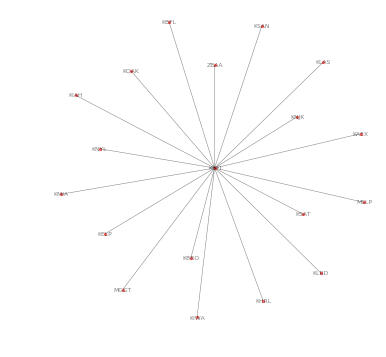

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

In [33]:
sg = next(nx.connected_component_subgraphs(g))

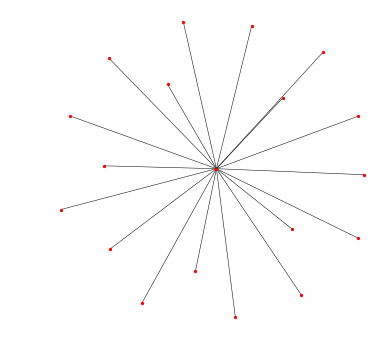

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(sg, ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [35]:
pos = {airport: (v['LongitudeDecimalDegrees'], v['LatitudeDecimalDegrees'])
       for airport, v in
       airports.to_dict('index').items()}

In [36]:
# Dropping unknown locations
pos_unknown = {k:v for k, v in pos.items() if v == (0.0, 0.0)}

In [37]:
needed_airports = set(flights['pickup_airport']).union(set(flights['dropoff_airport']))

In [38]:
set(pos_unknown.keys()).intersection(needed_airports)

set()

In [39]:
deg = nx.degree(sg)
sizes = [5 * deg[icao] for icao in sg.nodes]

In [40]:
# altitude = airports_us['alt']
# altitude = [altitude[icao] for icao in sg.nodes]

In [48]:
labels = {icao: icao if deg[icao] >= 1 else ''
          for icao in sg.nodes}

In [49]:
flights.head()

,year,R-T,pickup_airport,dropoff_airport,passengers,flights
MissionDate,,,,,,
2010-10-02,2010-10-01,R,KBFI,KSAN,53,1
2010-10-02,2010-10-01,T,KBFI,KIWA,1,1
2010-10-02,2010-10-01,T,KIWA,KBFI,26,1
2010-10-06,2010-10-01,R,KBFI,KHRL,18,1
2010-10-06,2010-10-01,T,KBFI,KIWA,28,1


In [50]:
pickup_totals = flights.groupby('pickup_airport')['passengers'].sum()
dropoff_totals = flights.groupby('dropoff_airport')['passengers'].sum()

In [51]:
dropoff_only = set(dropoff_totals.index).difference(set(pickup_totals.index))

In [52]:
passenger_totals = pd.concat([pickup_totals, dropoff_totals[dropoff_only]])

In [56]:
passenger_total = [passenger_totals[icao]/5 for icao in sg.nodes]

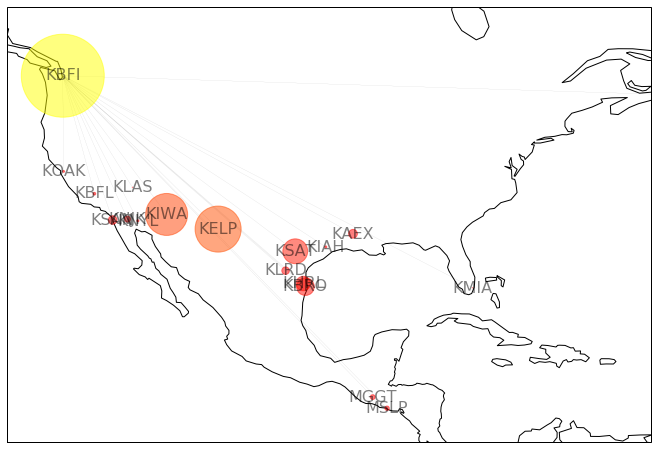

In [57]:
# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 10, 50])

nx.draw_networkx(sg, ax=ax,
                 font_size=16,
                 alpha=.5,
                 width=.075,
                 node_size=passenger_total,
                 node_color=passenger_total,
                 labels=labels,
                 pos=pos,
                 cmap=plt.cm.autumn)